## Rosbank ML Competition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

Загрузим данные об истории транзакций клиентов за 3 месяца льготного использования банковского продукта

In [2]:
raw_df = pd.read_csv('rosbank_train.csv').drop(columns=['target_sum'])
raw_df.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 9 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 33.7+ MB


Целью данной работы является прогноз оттока клиентов. Для этого необхоимо трансфрмировать датасет с транзакциями в агрегированный датасет для каждого клиента по следущим фичам:
    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИЕ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.   

Посчитаем общее кол-во клиентов в данном датасете:

In [4]:
print("Всего клиентов: ", len(raw_df.cl_id.unique()))

Всего клиентов:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [5]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  390573
Total transactions in test dataset:  99940


Для правильной подготовки фич исследуем следующие переменны: trx_category, MCC, колиество покупок в каждй валюте, TRDATETIME.

Для создания фичи из поля TRDATETIME создадим две функции для извлечения дня недели и часа соверешения операции

In [7]:
def get_day(date):
    date_format=datetime.datetime.strptime(date, '%d%b%y:%H:%M:%S')
    return date_format.strftime('%w')

def get_hour(date):
    date_format=datetime.datetime.strptime(date, '%d%b%y:%H:%M:%S')
    return date_format.strftime('%H')

Добавим в исходный датасет две переменные day_of_transaction и hour_of_transaction

In [8]:
transactions_train['day_of_transaction']=transactions_train.apply(lambda row: get_day(row.TRDATETIME), axis=1)
transactions_train['hour_of_transaction']=transactions_train.apply(lambda row: get_hour(row.TRDATETIME), axis=1)

Посмотрим, как распредлены переменные day_of_transaction и hour_of_transaction:

In [9]:
transactions_train['day_of_transaction'].value_counts()

5    62876
6    58802
4    56991
3    55533
2    54554
1    52316
0    49501
Name: day_of_transaction, dtype: int64

Кол-во транзакции в день не сильно отличается, поэтому для фич оставим все дни.

In [10]:
transactions_train['hour_of_transaction'].value_counts()

00    343982
13      3921
12      3809
11      3806
14      3524
10      3293
15      3280
16      3096
17      3084
18      2983
09      2959
19      2248
08      2145
07      1581
20      1494
06      1040
21      1004
05       822
22       688
04       549
23       388
03       374
02       294
01       209
Name: hour_of_transaction, dtype: int64

Подавляющее большинство транзакций отражено в 00:00, поэтому не имеет большего смысла использовать данную переменную как фичу.

Создадим агрегированный срез по дням недели:

In [11]:
all_days=transactions_train['day_of_transaction'].unique()
tmp_df_day_of_transaction = transactions_train.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0)
old_columns = [old_col for old_col in tmp_df_day_of_transaction.columns.tolist() if old_col in transactions_train['day_of_transaction'].unique()]
tmp_df_day_of_transaction .rename(columns={old_col: 'day_' + old_col for old_col in old_columns},inplace=True)

In [12]:
tmp_df_day_of_transaction.shape

(4000, 7)

In [13]:
tmp_df_day_of_transaction.head()

day_of_transaction,day_0,day_1,day_2,day_3,day_4,day_5,day_6
cl_id,,,,,,,
0,0.0,0.0,2.0,0.0,1.0,0.0,2.0
1,7.0,20.0,20.0,16.0,16.0,10.0,15.0
5,15.0,19.0,19.0,15.0,25.0,24.0,25.0
9,5.0,8.0,7.0,5.0,6.0,4.0,4.0
10,74.0,35.0,62.0,68.0,65.0,57.0,102.0


Рассмотрим переменную currency.

In [14]:
transactions_train.currency.value_counts().head(5)

810    380103
978      4528
840      1614
933       409
764       393
Name: currency, dtype: int64

Большинство покупок было совершено в рублях, евро и долларах, поэтому создадим фичи равные сумме покупки по каждому клиенту.

In [15]:
def get_name_curr(curr):
    if curr==810: 
        return "RUB"
    elif curr==978:
        return "EUR"
    elif curr==840:
        return "USD"
    else: 
        return "Other"

In [16]:
transactions_train['currency_name']=transactions_train.apply(lambda row: get_name_curr(row.currency),axis=1)
pd.options.display.float_format = '{:,.2f}'.format
tmp_df_curr_of_transaction=transactions_train.groupby(['cl_id','currency_name'])['amount'].sum().unstack().fillna(0)

In [17]:
tmp_df_curr_of_transaction.head()

currency_name,EUR,Other,RUB,USD
cl_id,,,,
0,0.00,0.00,"64,383.00",0.00
1,884.91,0.00,"266,693.13",0.00
5,51.83,"1,442.67","544,874.63",0.00
9,0.00,0.00,"849,315.09",0.00
10,0.00,0.00,"1,124,343.99",0.00


In [18]:
tmp_df_curr_of_transaction.shape

(4000, 4)

Рассмотрим переменную MCC.

In [19]:
mcc_stats=transactions_train.MCC.value_counts(dropna=False)
mcc_stats.head(40).index.tolist()

[5411,
 6011,
 5814,
 5812,
 5499,
 5541,
 5912,
 5999,
 6012,
 5921,
 5331,
 4121,
 5211,
 4829,
 5691,
 5261,
 4111,
 5977,
 5200,
 5732,
 5311,
 5651,
 5533,
 4812,
 5722,
 5661,
 5941,
 5641,
 8099,
 8999,
 5945,
 4814,
 7011,
 5712,
 7832,
 4112,
 7230,
 5699,
 5992,
 5813]

Оставим перве 30 категорий, как наиболее крупные

In [21]:
def get_new_MCC(MCC):
    if MCC not in [5411,6011,5814,5812,5499,5541,5912,5999,6012,5921,5331,4121,4829,5211,5691,5261,4111,5977,5311,5200,5732,
                   5651,5533,4812,5641,8999,5722,8099,5941, 5661,5945, 5712, 7011, 4814, 7832, 7230, 5964, 4112, 5699, 5813]:
        return "Other"
    else:
        return MCC

In [22]:
transactions_train['new_MCC']=transactions_train.apply(lambda row: get_new_MCC(row.MCC) ,axis=1)

In [23]:
transactions_train['new_MCC'].value_counts()

5411     95939
6011     43993
Other    35920
5814     33395
5812     23458
5499     21783
5541     15588
5912     14637
5999     10629
6012      8206
5921      6879
5331      5995
4121      5148
5211      5005
4829      4969
5691      4141
5261      3814
4111      3661
5977      3357
5200      2820
5732      2591
5311      2589
5651      2365
5533      2308
4812      2224
5722      2153
5661      2142
5941      2118
5641      2116
8099      2085
8999      2054
5945      1955
4814      1942
7011      1941
5712      1928
7832      1587
4112      1527
7230      1448
5699      1429
5813      1392
5964      1342
Name: new_MCC, dtype: int64

In [24]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [25]:
df_train_mcc = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='new_MCC'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='new_MCC'),
    left_index=True,
    right_index=True,
)

In [26]:
df_train_mcc.head()

new_MCC,new_MCC_mean_4111,new_MCC_mean_4112,new_MCC_mean_4121,new_MCC_mean_4812,new_MCC_mean_4814,new_MCC_mean_4829,new_MCC_mean_5200,new_MCC_mean_5211,new_MCC_mean_5261,new_MCC_mean_5311,...,new_MCC_sum_5977,new_MCC_sum_5999,new_MCC_sum_6011,new_MCC_sum_6012,new_MCC_sum_7011,new_MCC_sum_7230,new_MCC_sum_7832,new_MCC_sum_8099,new_MCC_sum_8999,new_MCC_sum_Other
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,0.00,0.00,0.00,0.00,"5,023.00",0.00,0.00,0.00,...,0.00,0.00,"20,000.00","36,562.00",0.00,0.00,0.00,0.00,0.00,0.00
1,17.10,0.00,0.00,0.00,0.00,0.00,23.90,0.00,0.00,0.00,...,"2,030.00",675.00,"145,000.00",0.00,0.00,0.00,14.00,0.00,0.00,"8,942.52"
5,420.00,943.30,0.00,0.00,960.00,0.00,0.00,678.00,0.00,0.00,...,"10,507.00",8.20,"208,000.00","33,878.38","2,940.00",110.00,0.00,0.00,0.00,"101,889.95"
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,"11,906.09","540,000.00","296,950.00",0.00,0.00,0.00,0.00,0.00,420.00
10,0.00,0.00,0.00,400.00,0.00,"1,141.73",342.06,501.33,0.00,"2,819.60",...,"1,961.48","12,123.23","854,000.00","47,694.98",0.00,0.00,0.00,611.00,"2,400.00","10,263.41"


In [27]:
df_train_mcc.shape

(4000, 82)

Рассмотрим переменную trx_category.

In [28]:
transactions_train.trx_category.value_counts(dropna=False)

POS               330605
DEPOSIT            16931
WD_ATM_ROS         15670
WD_ATM_PARTNER      8106
C2C_IN              5947
WD_ATM_OTHER        5746
C2C_OUT             4447
BACK_TRX            2125
CAT                  972
CASH_ADV              24
Name: trx_category, dtype: int64

In [29]:
transactions_train['trx_category']=transactions_train.apply(
    lambda row: row.trx_category if  row.trx_category not in ('CAT','CASH_ADV') else 'other',axis=1) 
                                            

In [30]:
df_train_trx=get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='trx_category')

In [31]:
df_train_trx.shape

(4000, 9)

Рассмотрим переменную channel_type.

In [32]:
transactions_train.channel_type.value_counts(dropna=False)

type1    237047
type2    140251
type5      4601
type4      3820
type3      2827
NaN        2027
Name: channel_type, dtype: int64

Пропущенные значения заполним наиболее другой категорией other.

In [33]:
transactions_train.channel_type.fillna("other",inplace=True)

In [34]:
transactions_train.channel_type.value_counts(dropna=False)

type1    237047
type2    140251
type5      4601
type4      3820
type3      2827
other      2027
Name: channel_type, dtype: int64

In [35]:
df_train_chanell=get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='channel_type')

In [36]:
df_train_chanell.head(5)

channel_type,channel_type_sum_other,channel_type_sum_type1,channel_type_sum_type2,channel_type_sum_type3,channel_type_sum_type4,channel_type_sum_type5
cl_id,,,,,,
0,"64,383.00",0.00,0.00,0.00,0.00,0.00
1,"267,578.04",0.00,0.00,0.00,0.00,0.00
5,"546,369.13",0.00,0.00,0.00,0.00,0.00
9,"849,315.09",0.00,0.00,0.00,0.00,0.00
10,"1,124,343.99",0.00,0.00,0.00,0.00,0.00


In [37]:
df_train = pd.merge(
    tmp_df_curr_of_transaction,
    tmp_df_day_of_transaction,
    left_index=True,
    right_index=True,
)

In [38]:
df_train.shape

(4000, 11)

In [39]:
df_train = pd.merge(
    df_train,
    df_train_mcc,
    left_index=True,
    right_index=True,
)

In [40]:
df_train.shape

(4000, 93)

In [41]:
df_train = pd.merge(
    df_train,
    df_train_trx,
    left_index=True,
    right_index=True,
)

In [42]:
df_train = pd.merge(
    df_train,
    df_train_chanell,
    left_index=True,
    right_index=True,
)

In [43]:
df_train.shape

(4000, 108)

In [44]:
df_targets = raw_df[['cl_id', 'target_flag']].drop_duplicates().copy()
df_targets.index = df_targets['cl_id']
df_targets = df_targets.drop('cl_id', axis=1)

In [45]:
df_train = pd.merge(
    df_train,
    df_targets,
    left_index=True,
    right_index=True,
    how='inner'
)
df_train.head()

,EUR,Other,RUB,USD,day_0,day_1,day_2,day_3,day_4,day_5,...,trx_category_sum_WD_ATM_PARTNER,trx_category_sum_WD_ATM_ROS,trx_category_sum_other,channel_type_sum_other,channel_type_sum_type1,channel_type_sum_type2,channel_type_sum_type3,channel_type_sum_type4,channel_type_sum_type5,target_flag
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,"64,383.00",0.00,0.00,0.00,2.00,0.00,1.00,0.00,...,0.00,0.00,0.00,"64,383.00",0.00,0.00,0.00,0.00,0.00,0
1,884.91,0.00,"266,693.13",0.00,7.00,20.00,20.00,16.00,16.00,10.00,...,0.00,"50,000.00",0.00,"267,578.04",0.00,0.00,0.00,0.00,0.00,0
5,51.83,"1,442.67","544,874.63",0.00,15.00,19.00,19.00,15.00,25.00,24.00,...,"6,000.00","66,500.00",0.00,"546,369.13",0.00,0.00,0.00,0.00,0.00,1
9,0.00,0.00,"849,315.09",0.00,5.00,8.00,7.00,5.00,6.00,4.00,...,"100,000.00","435,000.00",0.00,"849,315.09",0.00,0.00,0.00,0.00,0.00,0
10,0.00,0.00,"1,124,343.99",0.00,74.00,35.00,62.00,68.00,65.00,57.00,...,"5,400.00","422,300.00","37,694.98","1,124,343.99",0.00,0.00,0.00,0.00,0.00,0


In [46]:
df_train.shape

(4000, 109)

In [47]:
clf = LogisticRegression()
X_train = df_train.drop(['target_flag'], axis=1)
y_train = df_train['target_flag']

In [48]:
clf.fit(X=X_train, y=y_train)

D:\Netology\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [49]:
y_train_predict = clf.predict_proba(X_train)[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  0.76


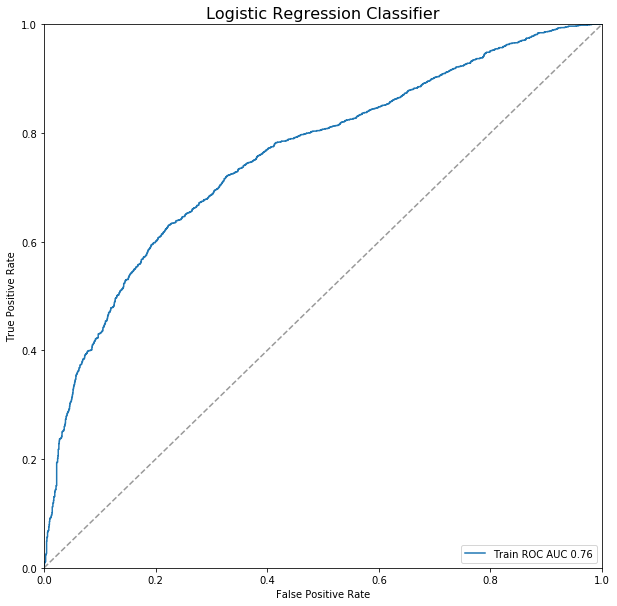

In [50]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Classifier', size=16)
plt.legend(loc='lower right')
plt.show()